# Detecting Building defects using  VGG16

### Importing necessary libraries

In [42]:
#!pip install keras

In [43]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob


### Image Data Agumentation¶

In [44]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#performing data agumentation on train data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
#performing data agumentation on test data
test_datagen = ImageDataGenerator(rescale = 1./255)

### Loading our data and performing data agumentation

In [45]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_26003f8055424cd8bd5dcb22f4a84693 = 'https://s3.eu.cloud-object-storage.appdomain.cloud'
else:
    endpoint_26003f8055424cd8bd5dcb22f4a84693 = 'https://s3.private.eu.cloud-object-storage.appdomain.cloud'

client_26003f8055424cd8bd5dcb22f4a84693 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='n1B2qQ0XeAlKocigJ_6voR2xrmb1z2Ks13KY0-EXjIvY',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_26003f8055424cd8bd5dcb22f4a84693)

streaming_body_2 = client_26003f8055424cd8bd5dcb22f4a84693.get_object(Bucket='wildplant-donotdelete-pr-qa75lezxztxqwl', Key='dataset.zip')['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [46]:
from io import BytesIO
import zipfile
unzip = zipfile.ZipFile(BytesIO(streaming_body_2.read()),'r')
file_paths = unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [47]:
pwd

'/home/wsuser/work'

In [7]:
import os
filenames = os.listdir('/home/wsuser/work/dataset/training_set')

In [8]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(r'/home/wsuser/work/dataset/training_set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 624 images belonging to 8 classes.


In [9]:
test_set = test_datagen.flow_from_directory(r'/home/wsuser/work/dataset/test_set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 269 images belonging to 8 classes.


In [10]:
print(training_set.class_indices)#checking the number of classes

{'Mountain Laurel_nonedible': 0, 'Peppergrass_edible': 1, 'Purple Deadnettle_edible': 2, 'Rhododendron_nonedible': 3, 'Toothwort_edible': 4, 'Wild Grape Vine_edible': 5, 'Wild Leek_edible': 6, 'rattlebox_nonedible': 7}


In [11]:
from collections import Counter as c
c(training_set .labels)

Counter({0: 72, 1: 120, 2: 72, 3: 72, 4: 72, 5: 72, 6: 72, 7: 72})

## Model Building

In [12]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = r'/home/wsuser/work/dataset/training_set'
valid_path = r'/home/wsuser/work/dataset/test_set'


In [13]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [14]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [15]:
  # useful for getting number of output classes
folders = glob(r'/home/wsuser/work/dataset/training_set/*')

In [16]:
folders

['/home/wsuser/work/dataset/training_set/Wild Leek_edible',
 '/home/wsuser/work/dataset/training_set/Wild Grape Vine_edible',
 '/home/wsuser/work/dataset/training_set/Rhododendron_nonedible',
 '/home/wsuser/work/dataset/training_set/Toothwort_edible',
 '/home/wsuser/work/dataset/training_set/Peppergrass_edible',
 '/home/wsuser/work/dataset/training_set/Mountain Laurel_nonedible',
 '/home/wsuser/work/dataset/training_set/Purple Deadnettle_edible',
 '/home/wsuser/work/dataset/training_set/rattlebox_nonedible']

In [17]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [18]:
x

<KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>

In [19]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [20]:

# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Compiling the model

In [21]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


### Fit the model

In [22]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(training_set,validation_data=test_set,epochs=10,steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1839: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
20/20 [==============================] - 371s 19s/step - loss: 2.7195 - accuracy: 0.2221 - val_loss: 1.6058 - val_accuracy: 0.4201
Epoch 2/10
20/20 [==============================] - 366s 19s/step - loss: 1.1852 - accuracy: 0.5858 - val_loss: 1.1286 - val_accuracy: 0.5985
Epoch 3/10
20/20 [==============================] - 358s 18s/step - loss: 0.7425 - accuracy: 0.7781 - val_loss: 1.0754 - val_accuracy: 0.5985
Epoch 4/10
20/20 [==============================] - 360s 18s/step - loss: 0.6466 - accuracy: 0.8094 - val_loss: 0.9768 - val_accuracy: 0.6691
Epoch 5/10
20/20 [==============================] - 365s 18s/step - loss: 0.4620 - accuracy: 0.8668 - val_loss: 1.0748 - val_accuracy: 0.6283
Epoch 6/10
20/20 [==============================] - 363s 18s/step - loss: 0.4076 - accuracy: 0.8929 - val_loss: 0.9590 - val_accuracy: 0.6691
Epoch 7/10
20/20 [==============================] - 357s 18s/step - loss: 0.3306 - accuracy: 0.9048 - val_loss: 0.9339 - val_accuracy: 0.6914
Epoch 

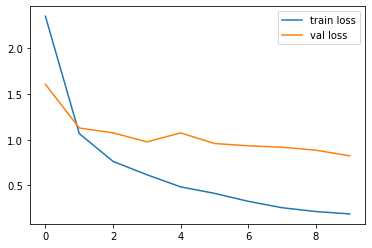

No handles with labels found to put in legend.


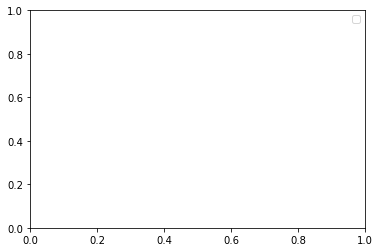

<Figure size 432x288 with 0 Axes>

In [69]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
#plt.plot(r.history['acc'], label='train acc')
#plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### Saving our model

In [70]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('WildPlantEdibility.h5')

In [71]:
!tar -zcvf image-classification-model_new.tgz WildPlantEdibility.h5

WildPlantEdibility.h5


In [72]:
ls -1

AccVal_acc.png
dataset/
image-classification-model_new.tgz
LossVal_loss.png
WildPlantEdibility.h5
wildplantproject.tar.gz
wildplant.tar.gz
WildPlant.tar.gz


In [73]:
!pip install watson-machine-learning-client --upgrade

In [74]:
from ibm_watson_machine_learning import APIClient

In [75]:
wml_credentials = {
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"ti_QA1MQ6v1kxbjQKasUso_AdswggpQbRu7236MY_ZcC"
}

In [76]:
client = APIClient(wml_credentials=wml_credentials)


In [77]:
def guid_from_space_name(client,space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [78]:
space_uid=guid_from_space_name(client,'wild_edibility')
print("Space UID="+space_uid)

Space UID=51ee5ddc-cd4b-48cd-a2a5-cf6d042212f1


In [79]:
#space_uid = guid_from_space_name(client=client,space_name = "wildplant_deploy")


In [80]:
client.set.default_space(space_uid)

'SUCCESS'

In [81]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029

In [82]:
#software_spec_uid=client.software_specifications.get_uid_by_name("tensorflow_1.15-py3.6")
software_spec_uid=client.software_specifications.get_uid_by_name("tensorflow_2.4-py3.7")
software_spec_uid

'65e171d7-72d1-55d9-8ebb-f813d620c9bb'

In [83]:
model_details = client.repository.store_model(model='image-classification-model_new.tgz',meta_props={
    client.repository.ModelMetaNames.NAME:"CNN",
    client.repository.ModelMetaNames.TYPE:"tensorflow_2.4",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid})

model_id = client.repository.get_model_uid(model_details)

In [84]:
model_id

'26cb701b-6987-4a64-ba26-001367be7384'

In [85]:
client.repository.download(model_id,'WildPlants.tar.gz')

Successfully saved model content to file: 'WildPlants.tar.gz'


'/home/wsuser/work/WildPlants.tar.gz'

In [86]:
#client.repository.download('b7899f9c-513e-41f0-998a-037f22c4c2bb','WildPlant.tar.gz')

In [87]:
pwd

'/home/wsuser/work'

### Predicitng our results

In [41]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model = load_model('WildPlantEdibility.h5') #loading our trained model

In [42]:
img=image.load_img(r'/home/wsuser/work/dataset/test_set/rattlebox_nonedible/images116.jpg',target_size=(224,224))
x=image.img_to_array(img)
#x=x/255C:\Users\HP\Desktop\Wild_ediblity\dataset\training_set
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
#model.predict(img_data)
a=np.argmax(model.predict(img_data), axis=1)


In [43]:
a

array([7])

In [44]:
index=['Mountain Laurel_nonedible', 'Peppergrass_edible', 'Purple Deadnettle_edible', 'Rhododendron_nonedible', 'Toothwort_edible', 'Wild Grape Vine_edible', 'Wild Leek_edible', 'rattlebox_nonedible']
result=str(index[a[0]])
result

'rattlebox_nonedible'

In [45]:
import tensorflow
tensorflow.__version__

'2.4.3'

In [46]:
from tensorflow import keras
keras.__version__

'2.4.0'